#### W205 Project 3 / Student Name: Sang-hyeb(Sam) Lee 
# 0. Importing Dependencies

In [10]:
from IPython.display import Image, display
#Using it since images did not appear correctly in github.

# 1. Data pipeline
## 1.1 Overview of the data pipeline

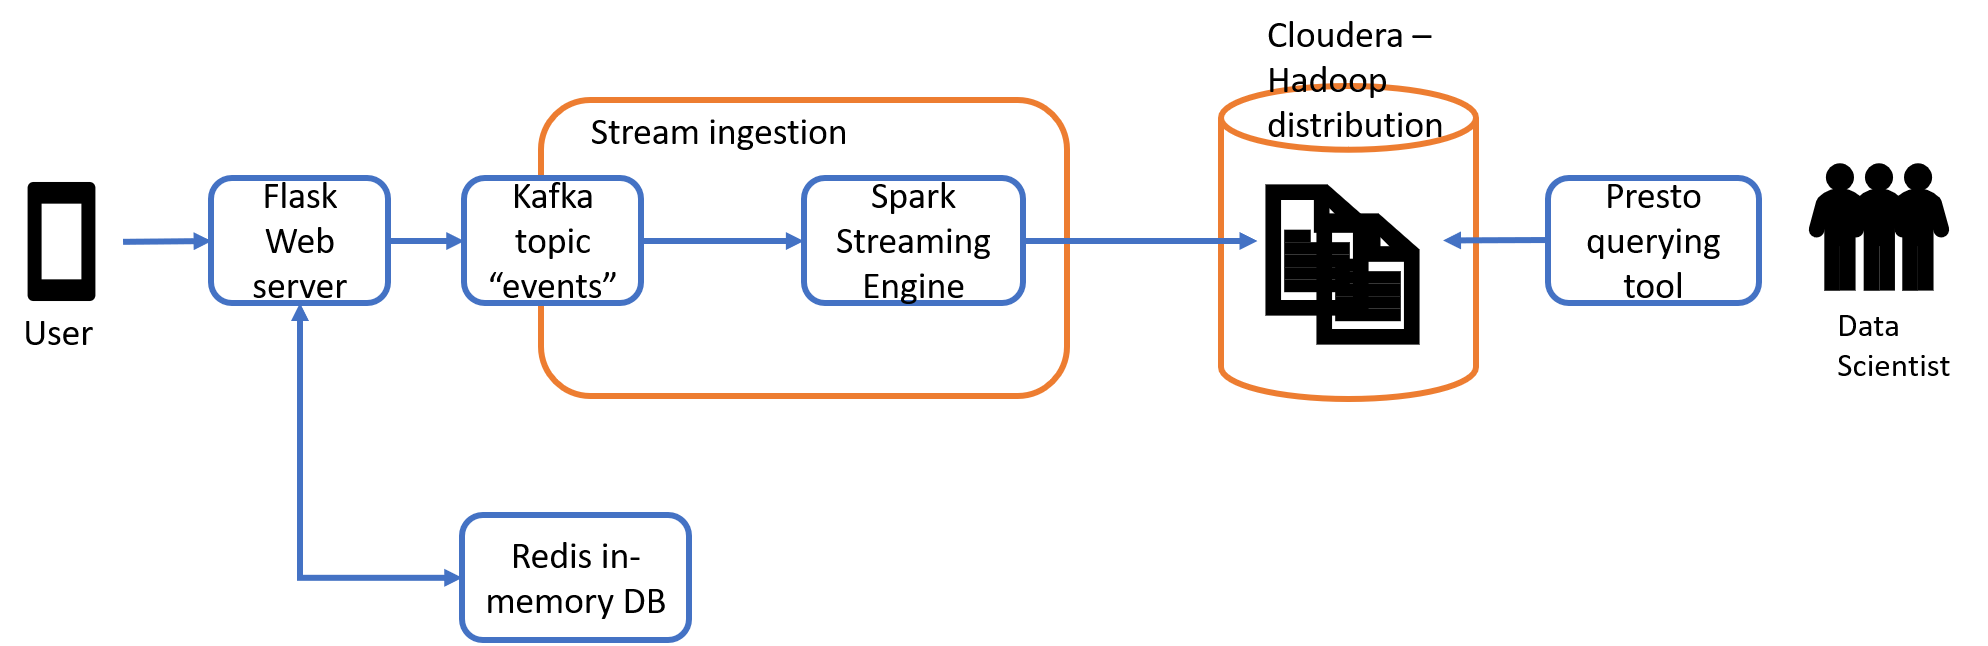

Figure 1: Overview of the data pipeline for project3


In [11]:
display(Image(filename="img/overview.png"))
print("Figure 1: Overview of the data pipeline for project3")

Figure 1.0 shows the overview of the data piepine for project3. It consists of Flask web-server, Kafka cluster, Sparking streaming engine, Cloudera, and Presto. Flask web server defines six endpoints which users interact with. User activities and the corresponding endpoints are explained in section 2.

Once Flask web server captures user activities, it logs those events to Kafka cluster. Flask also updates the user state(number of swords, total money) in Redis in-memory DB. Kafka cluster consists of one zookeeper and one broker. There is one Kafka topic, **"events"**, which is configured with one parition and one replication factor. 

Spark streaming engine reads data from the Kafka source, filters out the events, and write the filtered events to HDFS/parquet. Spark streaming queries are internally processed using a micro-batch processing engine, which is triggered every 10 second. Once data is written to HDFS in parquet format, data scientists can analyze the data using Presto.

## 1.2 Shell commands for starting up the data pipeline

| Index | command                                                                                             | description                     |
| :--- |:--- |:-:|
| 0 | docker-compose down -d                                                                              | start up the container          |
| 1| docker-compose exec mids env FLASK_APP=/w205/project-3-drminix/game_api.py flask run --host 0.0.0.0 | start up the flask server       |
|2 | bash generate_events.sh                                                                             | generate user events            |
|3 | docker-compose exec spark spark-submit /w205/project-3-drminix/write_spark_stream.py                | start up spark streaming engine |
|4 | docker-compose exec spark spark-submit /w205/project-3-drminix/write_hive_table.py                  | write table meta-data to hive   |
|5 | docker-compose exec presto presto --server presto:8080 --catalog hive --schema default              | start up presto                 |

# 2. User activities and Flask endpoints 

| index | user activities       | endpoints  | HTTP verb | example parameters                                     |
|-------|-----------------------|------------|-----------|--------------------------------------------------------|
| 1     | purchase a sword      | /sword     | POST      | {"user_name": "sam" , "sword_name": "big-sword1"}|
| 2     | earn money | /money     | POST      | {"user_name": "sam" , "amount":3.5} |
| 3     | spend money | /money     | DELETE      | {"user_name": "sam" , "amount":3.5} |
| 4     | join a guild          | /guild     | PUT       | {"user_name": "sam",<br>"guild_name": "guild1"}        |
| 5     | leave a guild         | /guild     | DELETE    | {"user_name": "sam",<br>"guild_name": "guild1"}        |
| 6     | show user status         | /user/(name)     | GET |         |





<center>Table 1: List of user of activities and corresponding endpoints on Kafka</center>

Table 1 shows the list of user activities and corresponding endpoints on Flask.  There are six user activities that are served by Flask endpoints.  These are (1) purchasing a sword, (2) earning money, (3) spending money, (4) joining a guild, (5) leaving a guild, and (6) viewing the live user status.  *game_apy.py* python file implements six end points. For example, the following is a python function which handles the */money* endpoint:
```python
##########################################
## endpoints related to money           ##
##########################################
#earn money
@app.route("/money", methods=["POST"])
def earn_money():
    #parse out data from payload
    request_data = request.get_json()
    user_name = request_data["user_name"]
    amount = int(request_data["amount"])
    
    #create an event
    earn_money_event = {'event_type': 'earn_money',
                        'user_name': user_name,
                        'amount': amount,
                        }
    #log to kafka
    log_to_kafka("events", earn_money_event)

    #update redis
    current_amount = r.get("user-money:{}".format(user_name))
    if current_amount is None:
        r.set("user-money:{}".format(user_name), amount)
    else:
        r.set("user-money:{}".format(user_name), amount+int(current_amount))

    #return message to user
    message = jsonify({"message": "User({}) earned ${}.)".format(user_name, amount)})
    return message
```

## 2.1 Emulating user behavior 

User activities are emulated using (1) Apache-bench(ab) tool and (2) Postman.

###  Apache Bench(ab)

Apache Bench(ab) tool is used to emulate user activities such as purchasing swords, speding money, and joining a guild. A bash shell script is written to automate the process. It uses a random number to decide weather (1) to buy a sword, (2) earn/spend money, or (3) join/leave a guild as shown below:

```shell
while true; do

    #(1) generate random transactions
    NUM=$(($RANDOM%10)) +1
    echo "Purchasing $NUM bigsword1 for user1"
    docker-compose exec mids ab -p "/w205/project-3-drminix/user1_sword1.json" -T application/json -n $NUM  http://localhost:5000/sword
    
    #(2) randomly earn money
    NUM=$(($RANDOM%100))
    if [ $NUM -lt 10 ] #earn money
        then 
        echo "Earned 10 dollars for user1"
        docker-compose exec mids ab -p "/w205/project-3-drminix/user1_earn10.json" -T application/json -n $NUM  http://localhost:5000/money
    else
        echo "Not earned any money for user1"
    fi
        
    #(3) randomly join a guild
    NUM=$(($RANDOM%100))
    if [ $NUM -lt 5 ] # number 0 ~ 4
        then
            echo "User1 joins guild1"
            docker-compose exec mids ab -p "/w205/project-3-drminix/user1_guild1.json" -T application/json -n 1 http://localhost:5000/guild
    elif [ $NUM -lt 10 ] #number 5~ 9
        then
            echo "User1 joins guild2"
            docker-compose exec mids ab -p "/w205/project-3-drminix/user1_guild2.json" -T application/json -n 1  http://localhost:5000/guild
    else
        echo "Not joining any guild"
    fi
    sleep 5
done
```
<center>Figure 2: shell script for emulating user activities</center>

### Postman 
Since Apache Benchmark tool does not support *HTTP DELETE Verb*, [Postman](https://www.postman.com/) is used to emulate *DELETE* events as shown below:

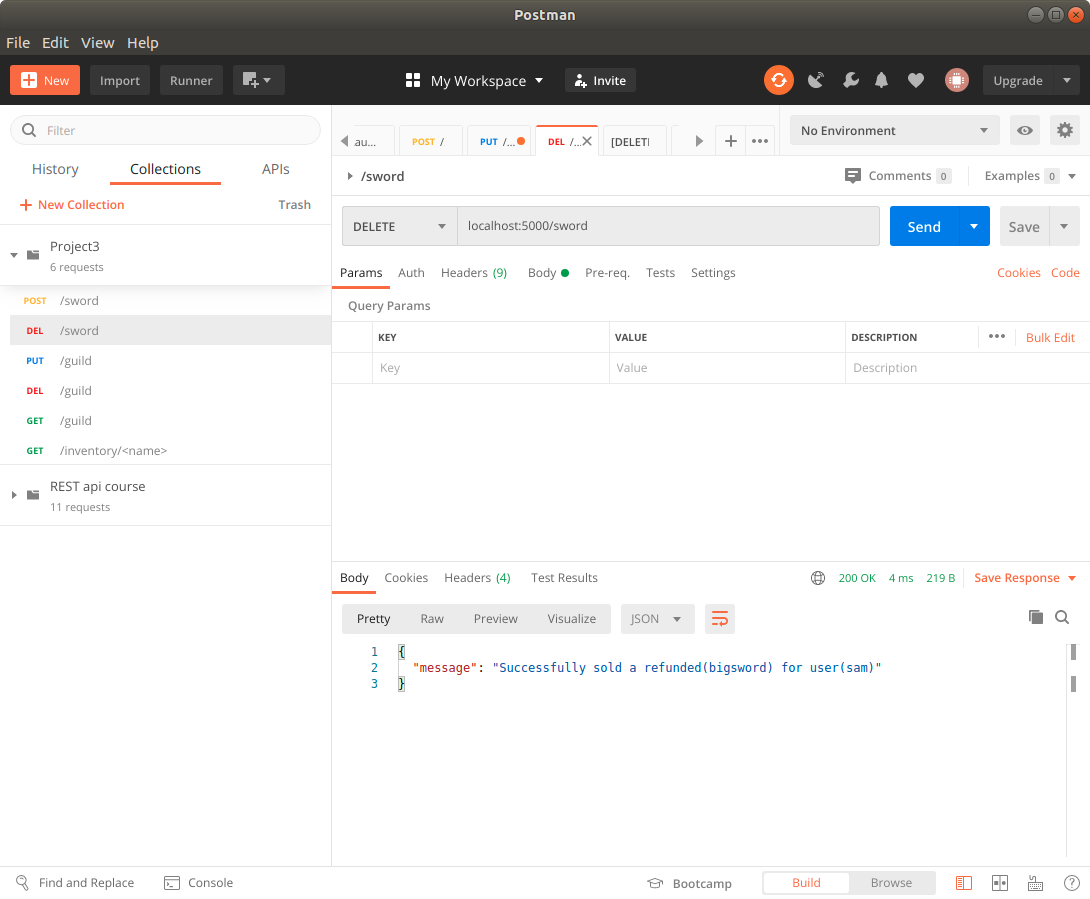

Figure 2:Emulating HTTP DELETE event with Postman


In [5]:
display(Image(filename="img/postman.png"))
print("Figure 2:Emulating HTTP DELETE event with Postman")

#### Checking user status via /user/<name>
User status can be checked by accessing "http://localhost:5000/user/* endpoint as shown below:

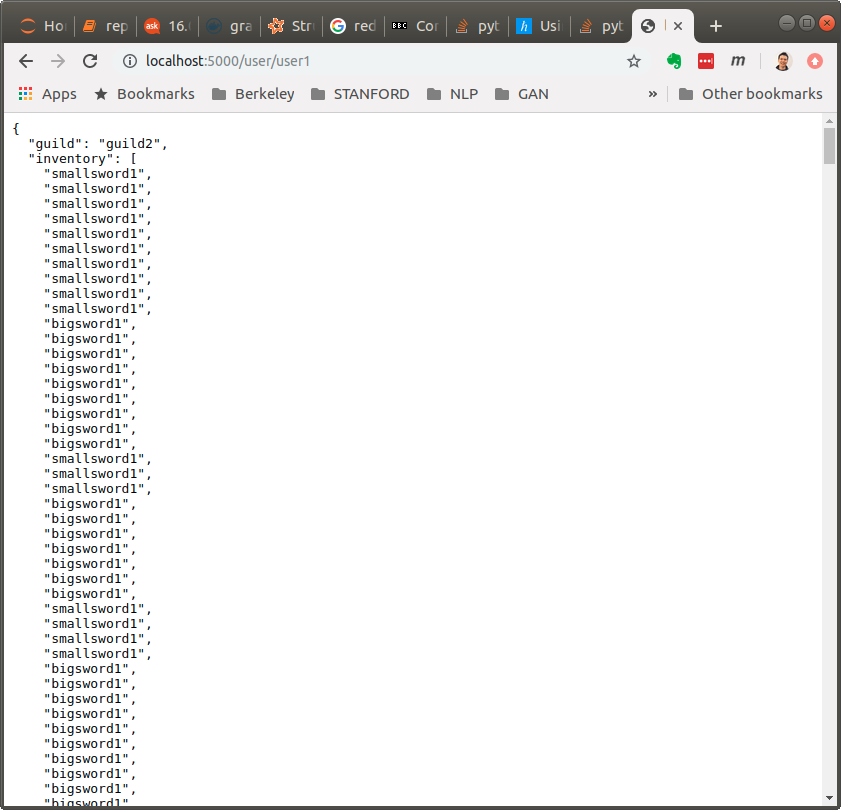

Figure 3:Viewing user status by visiting /user endpoint


In [6]:
display(Image(filename="img/status.png"))
print("Figure 3:Viewing user status by visiting /user endpoint")

# 3. Processing data with Spark Streaming Engine

Once flask logs user events to Kafka clusters, Spark streaming engine reads those events off Kafka *events* topic and pre-process them before writing to HDFS/parquet. Spark streaming engine is set up to filter the following five events:
1. purchase_sword
2. join_guild
3. leave_guild
4. earn_money
5. spend_money

*tracking_events.py* defines functions for filtering out those events. For example, the following is a python function which filters out *earn_money* and *spend_money* events:
```python
@udf('boolean')
def is_money_event(event_as_json):
    """udf for filtering events
    """
    event = json.loads(event_as_json)
    if event['event_type'] in ['earn_money', 'spend_money']:
        return True
    return False
```

*tracking_events.py* also implements functions for defining custom schema. For example, the following is a python function which defines a custom schema for "money_events" table:
```python
def money_event_schema():
    """
    root
    |-- Accept: string (nullable = true)
    |-- Host: string (nullable = true)
    |-- User-Agent: string (nullable = true)
    |-- event_type: string (nullable = true)
    |-- user_name: string (nullable = true)
    |-- money_amount: integer (nullable = true)
    |-- timestamp: string (nullable = true)
    """
    return StructType([
        StructField("Accept", StringType(), True),
        StructField("Host", StringType(), True),
        StructField("User-Agent", StringType(), True),
        StructField("event_type", StringType(), True),
        StructField("user_name", StringType(), True),
        StructField("amount", IntegerType(), True)
    ])
```


Once spark filters out requested events, it writes the following three tables into HDFS/parquet. 

1. /tmp/swords_events : stores purchase_sword events
2. /tmp/guild_events : stores join_guild, leavel_guild events
3. /tmp/money_events : stores earn_money, spend_money events

*write_spark_stream.py* starts up the spark streaming engine and *write_hive_table.py* writes metadata to hive so that data scientist can access tables in HDFS using Presto.


# 4. Exploratory Data Analysis using Presto

Once Spark streaming engine writes data to HDFS, it can be analyzed using Presto. Presto can be started using the following command:
```shell
docker-compose exec presto presto --server presto:8080 --catalog hive --schema default
```

Let's perform exploratory data analysis answer the following business questions: 
1. what's the most popular sword?
2. what's the average amount of money earned per user?
3. what's the number of members in each guild?

### most popular sword

```sql
presto:default> SELECT sword_name, count(*) FROM sword_events GROUP by sword_name;
 sword_name  | _col1 
-------------+-------
 smallsword2 |   315 
 bigsword1   |   636 
 smallsword1 |   318 
```

*bigsword1* is the most popular sword

### average user spending
```sql
presto:default> SELECT user_name, AVG(amount) AS amount FROM money_events WHERE event_type = 'spend_money' 
GROUP BY user_name;
 user_name |       amount       
-----------+--------------------
 user1     | 188.33333333333334 
 user3     |              300.0 
 user4     |              400.0 
 user5     |              400.0 
 user2     |              200.0 
(5 rows)
```


### Number of members in each guild

```sql
presto:default> SELECT guild_name, count(DISTINCT user_name) FROM guild_events GROUP BY guild_name; 
 guild_name | _col1 
------------+-------
 guild1     |     3 
 guild2     |     2 
 guild3     |     9 
(3 rows)
```

# 5. Structure of project3 submission
**NOTE**) This information is also written in README.md file

| index | filename              | description                                                                                                                                      |
|-------|-----------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|
| 1     | docker-compose.yml    | docker compose file for starting up the data pipeline                                                                                            |
| 2     | Dockerfile            | docker file which installs redis python package into midsw205/base<br>:0.1.9                                                                     |
| 3     | game_api.py           | python file for starting Flask webserver                                                                                                         |
| 4     | tracking_events.py    | python file which defines custom schema for Spark streaming engine                                                                               |
| 5     | write_spark_stream.py | python file which starts up the Spark streaming engine                                                                                           |
| 6     | write_hive_table.py   | python file which writes the table meta-data to hive                                                                                             |
| 7     | drminix-history.txt   | history file which contains shell commands. Please see report.ipynb for annoated history                                                         |
| 8     | generate_events.sh    | bash shell script used to emulate random user behaviors                                                                                          |
| 9     | *.json                | json file used to send POST/DELETE request to Flask server. <br>For example) user1_sword1.json represents an activity in which user1 buys sword1 |
| 10    | report.ipynb          | REPORT                                                                                                                                           |
| 11    | img folder            | images used in the report file                                                                                                                   |